# Locating bad datapoints

In this notebook we cover:

* Approaches for **locating outliers**
* Replacing missing data with **NaN** (how to do it and what choices we need to make)


Outliers are data points with extreme values, that is, unusually large or small compared to the rest of the dataset. Because of their extremity, outliers can distort summary statistics such as the mean and standard deviation, potentially leading to misleading conclusions.


In real datasets, outliers are common, often arising from one of the following causes:

* Real but unusual values 
    *  basketball players might constitute genuine outliers in terms of height
* Noise in measurement systems 
    * in brain imaging data, motion artefacts from head movements (MRI) or eye blinks (EEG) are much larger than the real neural signal we're trying to record
* Data entry error 
    * Humans make mistake - typing the wrong number, using incorrect units, or misplacing a decimal point. 
* Dummy or placeholder values
    * In some datasets an 'obviously wrong' or 'impossible' numerical value, such as 9999, is used to indicate a missing datapoint

Identifying and dealing with these kinds of bad datapoints is a crucial step in data cleaning (or *data wrangling*).
We need to decide whether to remove, replace, or retain outliers based on whether they represent genuine variability or error.


**Here is a video about types of outliers and how we might deal with them:**

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/DPp91QikW4M?si=OOQ_UtnGA8qBTdRu" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

## Set up Python Libraries

As usual you will need to run this code block to import the relevant Python libraries

In [6]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Import a dataset to work with

The data will be automatically loaded from the internet when you run the code block below:

We  will work with the file `heartAttack.csv`, which contains information on several thousand patients admitted to hospital in New York City, diagnosed with a heart attack. Using this dataset, we can explore how demographic and clinical factors affect two key outcomes:

* The duration of hospital stay, and
* The cost (in dollars) of treatment.

The dataset are downloaded with thanks (and with slight modifications for teaching purposes) from the website <a href="https://dasl.datadescription.com/">DASL</a> (Data and Story Library)

The data will be automatically loaded fromt he internet when you run this code block:

In [7]:
hospital=pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/heartAttack.csv')
display(hospital)

CHARGES  LOS   AGE SEX    DRG  DIED
0       4752.00   10  79.0   F  122.0   0.0
1       3941.00    6  34.0   F  122.0   0.0
2       3657.00    5  76.0   F  122.0   0.0
3       1481.00    2  80.0   F  122.0   0.0
4       1681.00    1  55.0   M  122.0   0.0
...         ...  ...   ...  ..    ...   ...
12839  22603.57   14  79.0   F  121.0   0.0
12840       NaN    7  91.0   F  121.0   0.0
12841  14359.14    9  79.0   F  121.0   0.0
12842  12986.00    5  70.0   M  121.0   0.0
12843       NaN    1  81.0   M  123.0   1.0

[12844 rows x 6 columns]

The columns of the dataframe are:
    
* `CHARGES` - dollar cost fo treatment
* `LOS` - length of hospital stay in days
* `AGE` - patient age in years
* `SEX` - patient's biological sex
* `DRG` - a code noted on dischaarge fromm hospital
* `DIED` - 1 if the patient died, 0 if they survived

## Finding outliers

When working with a new dataset, it’s always important to check for missing data and outliers. As you  will see, there are several simple ways to do this. Here we will cover 3 main ways to detect outliers:

1. *Min/Max*
2. *Plot*
3. *Standard Cutoff*

These are **not** mutually exclusive, and it often makes sense to consider each method as evidence for or against the presence of outliers.


### 1. Check min/max values are plausible

The first step will be to check whether the minimum and maximum values for each variable look plausible. Often, if a dataset contains an outlier or a misrecorded value, it will appear as the minimum or maximum in the summary statistics. Common causes for this can include:

* **Misplaced Decimal Points** - this can produce very large or small values.
    * e.g., a person's height could easily be misrecorded as 1765 cm (over 17 metres!) instead of 176.5 cm
* **Wrong Units** - mixing up our scale can also lead to extreme values
    * e.g., a person's height is recorded as 1.756 (m) when it should have been recorded as 176.5 (cm) 
* **Dummy Values** -*impossible* values can be used intentionally as placeholders for missing data
    * often the dummy value is `NaN` but sometimes an obviously-wrong numerical value (such as 99, 999 or 9999) is used, which will generally be a large number compared to real numerical values.
* **Zero as a Placeholder** sometimes `0` is used to mark missing data. This can be problematic as zero is often a plausible value for real data.
    * If a variable has a large nummber of zero values, it is worth considering whether these could be missing data rather than real zeros.

Because outliers can show up as extreme values, running `df.describe()` and checking the `min` and `max` values for each datapoint is a good first step in checking for outliers


Let's try it with our hospital dataset:

In [10]:
hospital.describe()

CHARGES           LOS           AGE           DRG          DIED
count  12145.000000  12844.000000  12842.000000  12841.000000  12841.000000
mean    9879.087615      8.345765     67.835072    121.690523      0.109805
std     6558.399650     88.309430    124.700554      0.658289      0.312658
min        3.000000      0.000000     20.000000    121.000000      0.000000
25%     5422.200000      4.000000     57.000000    121.000000      0.000000
50%     8445.000000      7.000000     67.000000    122.000000      0.000000
75%    12569.040000     10.000000     77.000000    122.000000      0.000000
max    47910.120000   9999.000000   9999.000000    123.000000      1.000000

Look carefully at the minimum and maximum values for each column — do any of them look implausible?

* The max values for length of stay (`LOS`) is 9999 days (about 3 years)
* The max value for Age (`AGE`) is 9999 years 

It looks like <tt>9999</tt> may have been used as a dummy value for missing data.

### 2. Plot the data

Often it it is a good idea to plot data in order to identify outliers. We can use a histogram plot to better understand whether a particular value is *suspicious* or just an extreme value in a natural occuring distribution. 

Let’s take a closer look at the column `CHARGES`.

* The maximum value of `CHARGES` is **\\$48910.12** is horrifyingly high, but since most of us are (fortunately) unfamiliar with medical billing, it is hard to say if this is an **outlier**
* The minimum value of **\\$3** is also suspicious, did they just give the patient a paracetomol and send them on their way?!

To get a clearer picture we can plot the distribution of `CHARGES`:



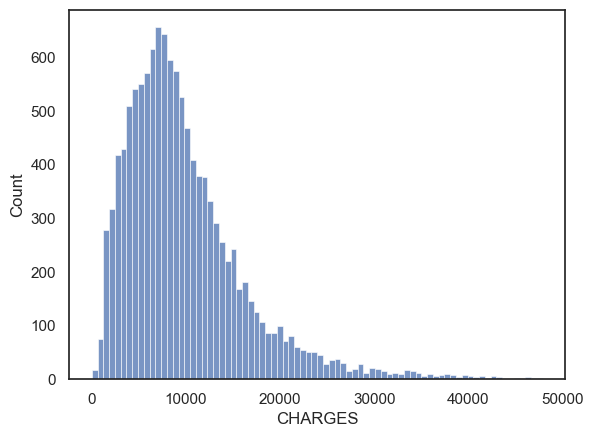

In [13]:
sns.histplot(data=hospital, x='CHARGES')
plt.show()

\$5 \$10

While the distribution of costs definitely looks skewed the maximum value of \$49000 appears to be the 'tip of the tail' rather than an actual outlier. The minimum value of \\$3 is also not particularly unique. 

In this case, **I wouldn't exclude any outliers from `CHARGES`**.

#### How will I know if it is a real outlier?

One way is to **plot the data**. By looking at the graph, you can then tell whether any datapoints seem to be separated from the main body of the data distribution.

Look what happens when we plot the distribution of Length of Stay (`LOS`)

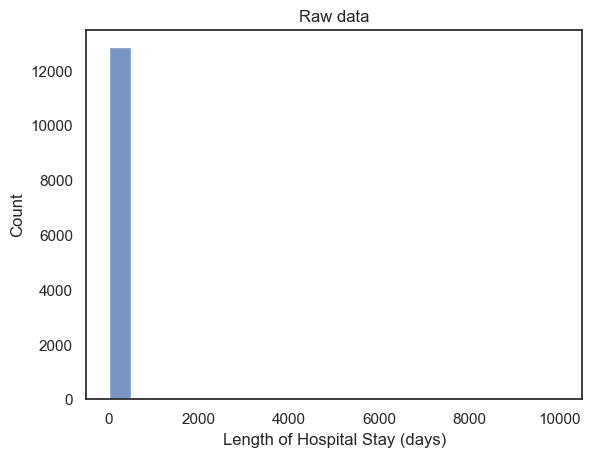

In [18]:
sns.histplot(data=hospital, x='LOS', bins=20)
plt.title('Raw data')
plt.xlabel('Length of Hospital Stay (days)')

plt.show()

When we plot the raw data, we can see that $x$ - axis extends all the way up to 10000. Remember the axis limits are automatically determined by the data. Here we can't actually see the bar at 9999 because only a few datapoints have this value compared to 12500 real datapoints!

**The scale of the axis indicates that there must be at least 1 data point whereby <tt>LOS~=10000</tt>:** 

* the autoscaling is a hint to use as data scientists that there are outlier values. 
* It's not a good way to present this fact to a client unfamiliar with `Seaborn`'s quirks!
* this is the kind of plot you make for yourself, *not something you put in a report*

Let's see what happens if we only plot hospital stays that are less than a year. To do this i will use the `.query()` function in my call to `sns.histplot`. I chose the cut-off value of 1-year arbitrarily. However, as you can see from the plot, there are no values that even approach 1 year, so I am happy with my choice of cut-off retained all real values of length of stay, and further confirms that the values of `LOS` close to 10000 are indeed outliers. 

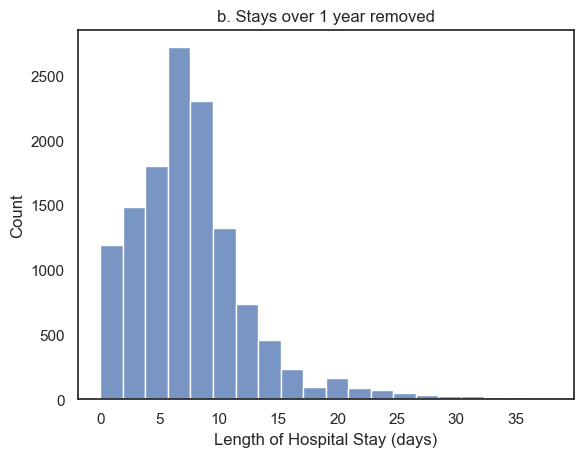

In [20]:
sns.histplot(data=hospital.query('LOS < 365'), x='LOS', bins=20)
plt.title('b. Stays over 1 year removed')
plt.xlabel('Length of Hospital Stay (days)')
plt.show()

You may want to plot the two plots above in a single figure. This can help you quickly compare the distributions with and without outliers. To do this we will use `plt.subplot()`. You may have to tweak the overall figure size and might want to adjust colors to get things looking nice.  

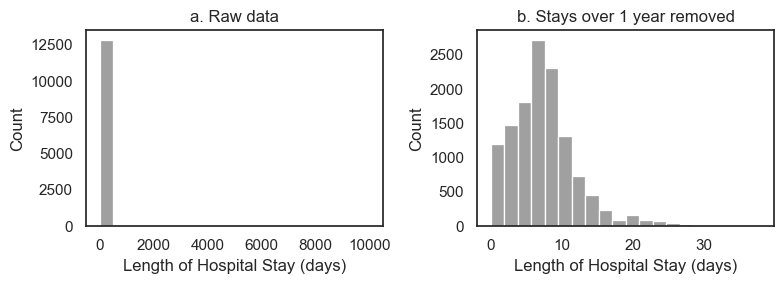

In [21]:
plt.figure(figsize=(8,3)) # when I first plotted this it looked a bit squashed so I adjusted the figsize

plt.subplot(1,2,1)
sns.histplot(data=hospital, x='LOS', bins=20, color='gray')
plt.title('a. Raw data')
plt.xlabel('Length of Hospital Stay (days)')

plt.subplot(1,2,2)
sns.histplot(data=hospital.query('LOS < 365'), x='LOS', bins=20, color='gray')
plt.title('b. Stays over 1 year removed')
plt.xlabel('Length of Hospital Stay (days)')

plt.tight_layout()
plt.show()

### 3. Use a 'standard' cut-off

Sometimes it's not so clear where to draw the line between real data and outliers. In this case, researchers may define outliers following a simple rule of thumb:

***Outliers can are data points which lay more than 3 standard deviations (SD) away from the mean.***

This rule of thumb is usally adequate becuase: 

* Under a normal distribution, values 3 standard deviations from the mean occur about 1 in 1000 times. So the 3xSD cut-off should exclude relatively few real values
* If your data are not Normally distributed, this cutoff may be less suitable.
* Don't worry if you don't know what normal distribution is yet - this will make sense when you come back and revise!


Let's check the suitability of the **3SD cutoff** for <tt>CHARGES</tt>. 

*Do you think this will work well?*

In [28]:
m = hospital.CHARGES.mean()
s = hospital.CHARGES.std()

cutoff = [m-3*s, m+3*s]

print('the low cutoff is: ' + str(cutoff[0]))
print('the high cutoff is: ' + str(cutoff[1]))

the low cutoff is: -9796.111336261192
the high cutoff is: 29554.286565573668


Let's replot the histogram with the cutoff values marked as red vertical lines:

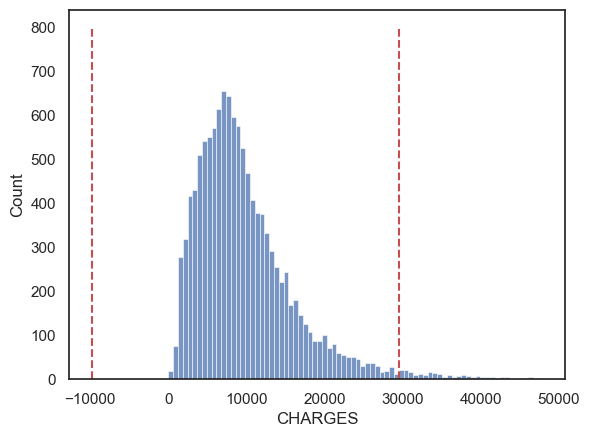

In [36]:
# re-plot the hisptogram so we can see where the 3SD cut-off falls
sns.histplot(data=hospital, x='CHARGES')
plt.plot([cutoff[0],cutoff[0]],[0, 800], 'r--')
plt.plot([cutoff[1],cutoff[1]],[0, 800], 'r--')
plt.show()

By this criterion, charges below ~-9800 dollars and above ~30000 are considered outliers.

**These are not good cut-off values!**
* Looking again at the histogram of CHARGES just above our high cutoff look no less plausible then CHARGES just below it.  
* -9800 dollars is an impossible value so we wouldn't include these cases anyway!

The 3SD approach didn't work so well in this case because the data distribution is very **skewed**. This results in values above our cutoff being actually quite plausible, whilst the natural cut-off value for low <tt>CHARGES</tt> (zero dollars) is not very far from the mean (in fact the minimum possible value, zero, is within the 3SD cutoff).